Este programa emplea la distribución de probabilidad exponencia para generar aleatoriamente los tiempos de llegada
de clientes a un establecimiento arbitrario, así como el tiempo que toma atenderlos.

Los parámetros son los siguientes:

* La tasa promedio de atención de clientes es de 15 clientes por hora, a través de 3 cajas.
* La tasa promedio de llegada de clientes es de 12 clientes por hora.

Se calculará, además:

1.	Cantidad de clientes totales atendidos en el día
2.	Tiempo de espera promedio por cliente
3.	Tiempo promedio de ocio por caja
4.	Máximo tiempo de espera de un cliente
5.	Mínimo tiempo de espera de un cliente
6.	Tiempo efectivo laborado por caja

Estos datos ayudarán a determinar si se debe mantener, incrementar o disminuir el número de cajas.

In [66]:
# Importación de librerías
import numpy
import simpy
import matplotlib.pyplot as plt
import datetime as dt
import os

**Nota:** la simulación se llevará a cabo en minutos

In [67]:
# Se define una semilla para el generador de números aleatorios, tal que se pueda reproducir la simulación
semilla = 0
numpy.random.seed(semilla)

In [68]:
# Funciones generadoras de variables aleatorias

# Usado para la simulación con la distribución exponencial
def generar_tiempo_llegada(lambda_llegada):
    return round(
        numpy.random.exponential(1 / lambda_llegada) * 60
    )

def generar_tiempo_atencion(lambda_atencion):
    # Obtener la tasa promedio de atención por caja por minuto
    return round(
        numpy.random.exponential(1 / lambda_atencion) * 60
    )

# Usado para la simulación con la distribución de Poisson
def generar_cantidad_clientes(lambda_llegada):
    return numpy.random.poisson(lambda_llegada / 60, 1)[0] # Se divide lambda_llegada entre 60 para obtener la tasa promedio de llegada por minuto

In [69]:
# Se define una interfaz a través de la cual se podrá decidir dónde se registrarán los mensajes
# de salida de la simulación
class MessageProcessor:
    def __init__(self,):
        pass

    def process(self, message):
        pass

    def stop(self):
        pass

# Se define una clase que permitirá registrar los mensajes de salida de la simulación en un archivo
class FileMessageProcessor(MessageProcessor):
    def __init__(self, file_path):
        self.file_path = file_path
        self.file = open(self.file_path, "w")

    def process(self, message):
        self.file.write(message + "\n")

    def stop(self):
        self.file.close()

# Se define una clase que permitirá registrar los mensajes de salida de la simulación en la consola
class ConsoleMessageProcessor(MessageProcessor):
    def __init__(self,):
        pass

    def process(self, message):
        print(message)

    def stop(self):
        pass

In [70]:
# Se define una clase que lleva a cabo la supervisión de las métricas de desempeño de la simulación
class Metrics:
    def __init__(self, duracion_simulacion : int, cajas : list[simpy.Resource] = []):
        self.clientes_totales = 0
        self.clientes_atendidos = 0
        self.tiempos_efectivos = {}
        self.tiempos_espera = {}
        self.maxima_espera = 0
        self.minima_espera = 0
        self.duracion_simulacion = duracion_simulacion
        self.cajas = cajas

    def registrar_cliente(self):
        self.clientes_totales += 1

    def registrar_cliente_atendido(self):
        self.clientes_atendidos += 1

    def registrar_tiempo_espera(self, caja : simpy.Resource, tiempo_espera : int):

        if tiempo_espera > self.maxima_espera:
            self.maxima_espera = tiempo_espera

        if tiempo_espera < self.minima_espera:
            self.minima_espera = tiempo_espera

        if caja in self.tiempos_espera:
            self.tiempos_espera[caja] = self.tiempos_espera[caja] + tiempo_espera
        else:
            self.tiempos_espera[caja] = tiempo_espera

    def registrar_tiempo_efectivo(self, caja : simpy.Resource, tiempo_efectivo : int):
        if caja in self.tiempos_efectivos:
            self.tiempos_efectivos[caja] = self.tiempos_efectivos[caja] + tiempo_efectivo
        else:
            self.tiempos_efectivos[caja] = tiempo_efectivo

    def tiempo_espera_total(self):    
        return sum((self.tiempos_espera[caja] for caja in self.cajas))

    def tiempo_espera_por_caja(self, caja : simpy.Resource):
        return self.tiempos_espera[caja]

    def tiempo_espera_promedio(self):
        return self.tiempo_espera_total() / self.clientes_atendidos

    def tiempos_efectivo_total(self):
        return sum((self.tiempos_efectivos[caja] for caja in self.cajas))

    def tiempo_efectivo_por_caja(self, caja : simpy.Resource):
        return self.tiempos_efectivos[caja]

    def tiempo_efectivo_promedio(self):
        return self.tiempos_efectivo_total() / len(self.cajas)

    def reiniciar(self):
        self.clientes_totales = 0
        self.clientes_atendidos = 0
        self.tiempos_espera = {}
        self.tiempos_efectivos = {}
        self.maxima_espera = 0
        self.minima_espera = 0

In [71]:
# Función para reportar el tiempo de la simulación en formato hh:mm
def desc_minutos(hora_inicio, minutos):
    return (
        dt.datetime.combine(dt.date.today(), hora_inicio) + dt.timedelta(minutes=minutos)
    ).strftime("%H:%M")

In [72]:
# Función que selecciona la caja que se desocupará primero
def decidir_mejor_caja(cajas, tiempos_restantes):

    menor_tiempo = tiempos_restantes[cajas[0]]
    mejor_caja = cajas[0]
    
    for caja in cajas:
        if tiempos_restantes[caja] < menor_tiempo:
            menor_tiempo = tiempos_restantes[caja]
            mejor_caja = caja

    return mejor_caja

In [73]:
def atender_cliente(
    entorno,
    id_cliente,
    caja,
    id_caja,
    tiempo_atencion,
    hora_inicio,
    monitor_metricas : Metrics,
    procesador_mensajes : MessageProcessor
):

    # Se registra la llegada del cliente
    min_llegada = entorno.now
    msg_llegada = f"El cliente #{id_cliente} llega a la cola en el tiempo {desc_minutos(hora_inicio, min_llegada)}\n"
    procesador_mensajes.process(msg_llegada)
    
    with caja.request() as peticion:

        # Se espera a ser atendido
        yield peticion

        # Se atiende al cliente
        min_atencion = entorno.now
        msg_atencion = f"El cliente #{id_cliente} es atendido en la caja #{id_caja} en el tiempo {desc_minutos(hora_inicio, min_atencion)}\n"
        procesador_mensajes.process(msg_atencion)
        yield entorno.timeout(tiempo_atencion)

        # Se registra la salida del cliente
        monitor_metricas.registrar_tiempo_efectivo(caja, tiempo_atencion)
        monitor_metricas.registrar_cliente_atendido()
        msg_salida = f"El cliente #{id_cliente} termina de ser atendido a las {desc_minutos(hora_inicio, entorno.now)}\n"
        procesador_mensajes.process(msg_salida)
        
        # Se calcula el tiempo de espera
        tiempo_espera = min_atencion - min_llegada
        monitor_metricas.registrar_tiempo_espera(caja, tiempo_espera)

In [74]:
def sistema_colas_exponencial(
    entorno,
    lambda_llegada,
    lambda_atencion,
    cajas,
    tiempos_restantes,
    hora_inicio,
    monitor_metricas : Metrics,
    procesador_mensajes : MessageProcessor
):

    """
        Este proceso se encarga de atender a los clientes que llegan al sistema de colas.
        A través de una variable aleatoria de distribución exponencial, se determina el
        tiempo que tardará en llegar el siguiente cliente.
    """

    id_cliente = 0

    while True:

        yield entorno.timeout(generar_tiempo_llegada(lambda_llegada))
        
        id_cliente += 1
        monitor_metricas.registrar_cliente()
        
        # Se selecciona la caja que se desocupará primero
        mejor_caja = decidir_mejor_caja(cajas, tiempos_restantes)
        id_caja = cajas.index(mejor_caja) + 1

        # Se genera el tiempo de atención del cliente
        tiempo_atencion = generar_tiempo_atencion(lambda_atencion/len(cajas))
        # Se registra el tiempo de atención del cliente en la caja
        tiempos_restantes[mejor_caja] += tiempo_atencion
        
        # Se inicia el proceso de atención del cliente
        entorno.process(
            atender_cliente(entorno, id_cliente, mejor_caja, id_caja, tiempo_atencion, hora_inicio, monitor_metricas, procesador_mensajes)
        )

In [75]:
# Se declara el proceso que monitorea el estado de las cajas
def disminuir_tiempo_restante(entorno, cajas, tiempos_restantes):

    """
        Este proceso se encarga de disminuir minuto a minuto el tiempo de atención restante de cada caja.
        Esto permite conocer con mayor precisión este dato, ya que en el proceso de atención de clientes
        únicamente se conoce el momento en el que la atención inicia y en el que termina, pero cuando llega
        un nuevo cliente no se puede conocer con exactitud cuánto progreso se ha hecho en la atención del
        cliente en turno, por lo que determinar la caja más óptima requiere de mayor precisión.

        * Nota: Si el tiempo de atención restante es 0, significa que la caja está desocupada, por lo que
        se deja de restar tiempo de atención restante.
    """
    
    while True:

        yield entorno.timeout(1)

        for caja in cajas:
            
            tiempo_atencion_restante = tiempos_restantes[caja]
            
            if tiempo_atencion_restante > 0:
                tiempos_restantes[caja] -= 1 

In [76]:
def sistema_colas_poisson(
    entorno,
    lambda_llegada,
    lambda_atencion,
    cajas,
    tiempos_restantes,
    hora_inicio,
    monitor_metricas : Metrics,
    procesador_mensajes : MessageProcessor
):

    """
        Este proceso se encarga de atender a los clientes que llegan al sistema de colas.
        A través de una variable aleatoria de distribución de Poisson, se determina la
        cantidad de clientes que llegan en cada minuto.
    """

    id_cliente = 0
    cant_clientes = 0

    while True:

        yield entorno.timeout(1)
        
        # Se actualizan los tiempos restantes de atención de cada caja
        for caja in cajas:
            
            tiempo_atencion_restante = tiempos_restantes[caja]
            
            if tiempo_atencion_restante > 0:
                tiempos_restantes[caja] -= 1

        # Se genera la cantidad de clientes que llegan en el minuto actual
        cant_clientes = generar_cantidad_clientes(lambda_llegada)
        
        # Se atienden los clientes que llegaron en el minuto actual
        for cliente in range(cant_clientes):
            
            id_cliente += 1
            monitor_metricas.registrar_cliente()

            # Se selecciona la caja que se desocupará primero
            mejor_caja = decidir_mejor_caja(cajas, tiempos_restantes)
            id_caja = cajas.index(mejor_caja) + 1

            # Se genera el tiempo de atención del cliente
            tiempo_atencion = generar_tiempo_atencion(lambda_atencion/len(cajas))
            tiempos_restantes[mejor_caja] += tiempo_atencion
            
            # Se inicia el proceso de atención del cliente
            entorno.process(
                atender_cliente(entorno, id_cliente, mejor_caja, id_caja, tiempo_atencion, hora_inicio, monitor_metricas, procesador_mensajes)
            )

In [77]:
def simular_exponencial(
    entorno : simpy.Environment,
    duracion_simulacion : int,
    lambda_llegada,
    lambda_atencion,
    cajas : list[simpy.Resource],
    tiempos_restantes : dict,
    hora_inicio,
    monitor_metricas : Metrics,
    procesador_mensajes : MessageProcessor
):
    # Se asignan los procesos del sistema de colas y de monitoreo de cajas al entorno
    entorno.process(sistema_colas_exponencial(entorno, lambda_llegada, lambda_atencion, cajas, tiempos_restantes, hora_inicio, monitor_metricas, procesador_mensajes))          
    entorno.process(disminuir_tiempo_restante(entorno, cajas, tiempos_restantes))
    # Se ejecuta la simulación hasta que se cumpla el tiempo indicado
    entorno.run(until=duracion_simulacion)

def simular_poisson(
    entorno : simpy.Environment,
    duracion_simulacion : int,
    lambda_llegada,
    lambda_atencion,
    cajas : list[simpy.Resource],
    tiempos_restantes : dict,
    hora_inicio,
    monitor_metricas : Metrics,
    procesador_mensajes : MessageProcessor,
):
    entorno.process(sistema_colas_poisson(entorno, lambda_llegada, lambda_atencion, cajas, tiempos_restantes, hora_inicio, monitor_metricas, procesador_mensajes))
    entorno.run(until=duracion_simulacion)

In [78]:
def ejecutar_simulacion(
    entorno : simpy.Environment,
    duracion_simulacion : int,
    hora_inicio : dt.time,
    dist : str,
    n_servidores : int,
    lambda_llegada : float,
    lambda_atencion : float,
    monitor_metricas : Metrics,
    procesador_mensajes : MessageProcessor = ConsoleMessageProcessor(),
):

    """
        Esta función se encarga de ejecutar la simulación del sistema de colas, empleando como unidad de tiempo
        los minutos.
        
        Es posible indicar la distribución de probabilidad de llegada de clientes, ya sea exponencial
        (que calculará los tiempos que tardan en llegar un cliente tras otro) o de Poisson (que calculará
        la cantidad de clientes que llegan en un minuto).

        * Nota: Si la lambda está indicada en horas, se debe indicar el parámetro lambda_horas como verdadero.

        @param entorno: Entorno de simulación
        @param duracion_simulacion: Duración de la simulación en minutos
        @param hora_inicio: Hora de inicio de la simulación
        @param dist: Distribución de probabilidad de llegada de clientes ("exp" o "poi")
        @param n_servidores: Número de cajas
        @param lambda_llegada: Tasa promedio de llegada de clientes por hora
        @param lambda_atencion: Tasa promedio de atención de clientes por hora
        @param monitor_metricas: Objetos que almacena datos de la simulación para su posterior análisis
        @param procesador_mensajes: Procesador de mensajes, por defecto se muestra en consola
    """

    # Se crean las cajas
    cajas = [simpy.Resource(entorno, capacity=1) for i in range(n_servidores)]
    monitor_metricas.cajas = cajas

    # En este diccionario se almacena el tiempo de atención restante de cada caja
    tiempos_restantes = {}
    for caja in cajas:
        tiempos_restantes[caja] = 0

    # Se ejecuta la simulación de acuerdo a la distribución de probabilidad indicada
    if dist == "exp":
        simular_exponencial(entorno, duracion_simulacion, lambda_llegada, lambda_atencion, cajas, tiempos_restantes, hora_inicio, monitor_metricas, procesador_mensajes)
    elif dist == "poi":
        simular_poisson(entorno, duracion_simulacion, lambda_llegada, lambda_atencion, cajas, tiempos_restantes, hora_inicio, monitor_metricas, procesador_mensajes)
    else:
        raise Exception("Distribución no válida")

    # Se informa al procesador de mensajes que se ha terminado la simulación
    procesador_mensajes.stop()

In [79]:
# Se determina la duración de la simulación
hora_inicio = dt.time(7, 0, 0) # 7:00 am
hora_fin = dt.time(22, 0, 0) # 10:00 pm
duracion_simulacion = (hora_fin.hour - hora_inicio.hour) * 60 # Duración de la simulación en minutos

monitor_metricas = Metrics(duracion_simulacion)

# Se ejecuta
ejecutar_simulacion(
    entorno = simpy.Environment(),
    duracion_simulacion = duracion_simulacion,
    hora_inicio = hora_inicio,
    dist = "exp", # Distribución de probabilidad de llegada de clientes ("exp" o "poi")
    n_servidores = 3,
    lambda_llegada = 12,
    lambda_atencion = 15,
    monitor_metricas = monitor_metricas,
)

El cliente #1 llega a la cola en el tiempo 07:04

El cliente #1 es atendido en la caja #1 en el tiempo 07:04

El cliente #2 llega a la cola en el tiempo 07:09

El cliente #2 es atendido en la caja #2 en el tiempo 07:09

El cliente #3 llega a la cola en el tiempo 07:12

El cliente #3 es atendido en la caja #3 en el tiempo 07:12

El cliente #4 llega a la cola en el tiempo 07:15

El cliente #2 termina de ser atendido a las 07:18

El cliente #4 es atendido en la caja #2 en el tiempo 07:18

El cliente #1 termina de ser atendido a las 07:19

El cliente #3 termina de ser atendido a las 07:24

El cliente #5 llega a la cola en el tiempo 07:32

El cliente #5 es atendido en la caja #1 en el tiempo 07:32

El cliente #5 termina de ser atendido a las 07:38

El cliente #6 llega a la cola en el tiempo 07:40

El cliente #6 es atendido en la caja #1 en el tiempo 07:40

El cliente #7 llega a la cola en el tiempo 07:44

El cliente #8 llega a la cola en el tiempo 07:44

El cliente #7 es atendido en la caja

In [80]:
# Se reportan los resultados de la simulación
print(f"🙂   Clientes que llegaron: {monitor_metricas.clientes_totales}")
print(f"😊✨ Clientes que fueron atendidos: {monitor_metricas.clientes_atendidos}")
print(f"⌛    Tiempo promedio de espera: {int(monitor_metricas.tiempo_espera_promedio())} minutos")
print(f"⌛😡  Máximo tiempo de espera: {monitor_metricas.maxima_espera} minutos")
print(f"⌛💚  Mínimo tiempo de espera: {monitor_metricas.minima_espera} minutos")
print(f"🔨    Tiempo efectivo laborado por caja:")

i = 1
for tiempo in monitor_metricas.tiempos_efectivos.values():
    print(f"\tCaja #{i}: {tiempo} min.")
    i += 1

print(f"😴   Tiempo de ocio por caja:")

i = 1
for tiempo in monitor_metricas.tiempos_efectivos.values():
    print(f"\tCaja #{i}: {duracion_simulacion - tiempo} min.")
    i += 1

🙂   Clientes que llegaron: 181
😊✨ Clientes que fueron atendidos: 177
⌛    Tiempo promedio de espera: 5 minutos
⌛😡  Máximo tiempo de espera: 33 minutos
⌛💚  Mínimo tiempo de espera: 0 minutos
🔨    Tiempo efectivo laborado por caja:
	Caja #1: 657 min.
	Caja #2: 725 min.
	Caja #3: 570 min.
😴   Tiempo de ocio por caja:
	Caja #1: 243 min.
	Caja #2: 175 min.
	Caja #3: 330 min.


In [81]:
# Se llevará a cabo una simulación para múltiples números de cajas, con el fin de determinar cuál es el número óptimo
# de cajas para el sistema, tanto para la distribución exponencial como para la de Poisson.

distribuciones = ("exp", "poi")
numeros_cajas = list(range(1,10,2)) # Se simulará con 1, 3, 5, 7 y 9 cajas

cants_clientes_atendidos = []
tiempos_promedio_espera = []
tiempos_efectivos_promedio_globales = []

variables_a_graficar = [
    ("Clientes atendidos", cants_clientes_atendidos),
    ("Promedio de espera (min.)", tiempos_promedio_espera),
    ("Tiempo efectivo global (hrs.)", tiempos_efectivos_promedio_globales),
]

In [82]:
def colores():
    yield "red"
    yield "green"
    yield "blue"
    yield "orange"
    yield "purple"
    yield "brown"
    yield "pink"
    yield "gray"
    yield "olive"
    yield "cyan"

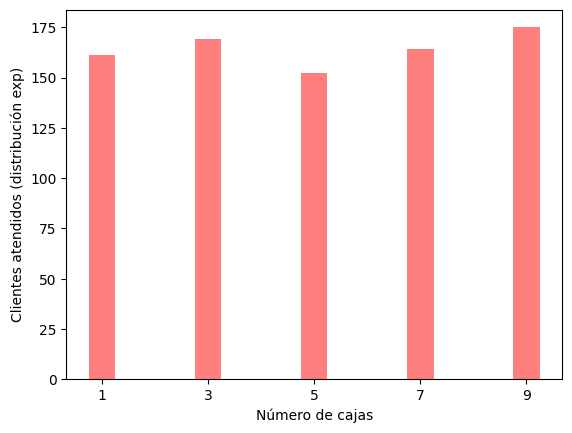

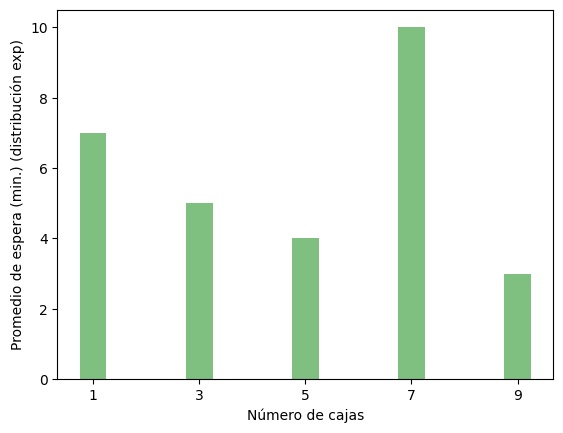

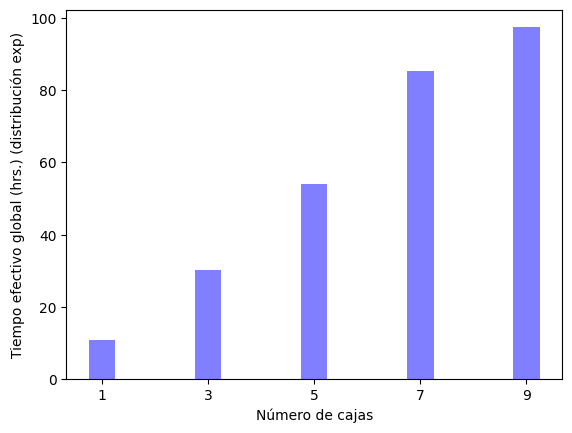

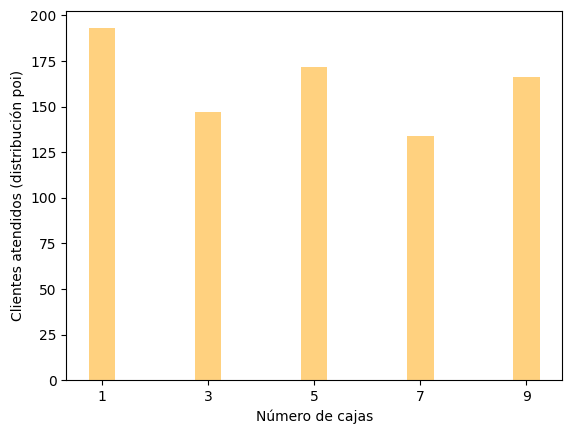

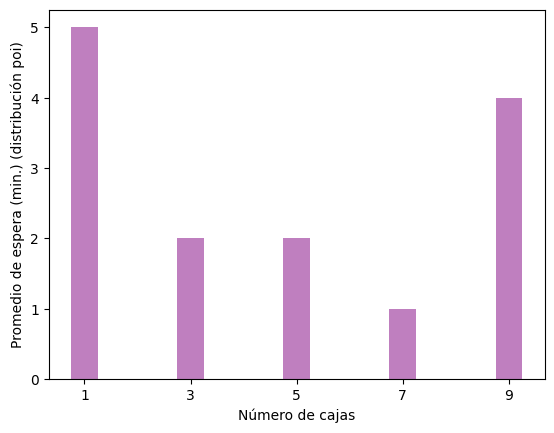

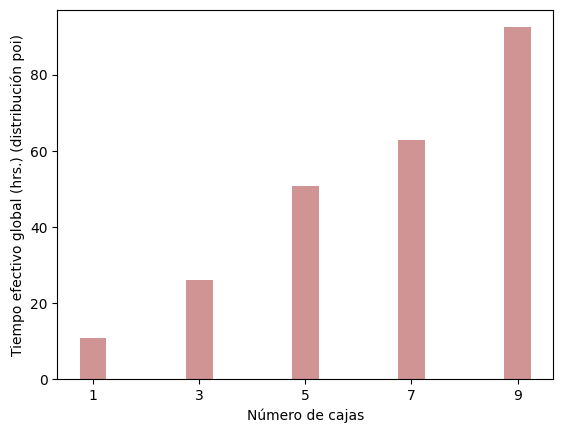

In [83]:
# Se grafican los resultados
ancho_barras = 1 / (len(variables_a_graficar) + 1)
posiciones = numpy.arange(len(numeros_cajas))
colores_gen = colores()
monitor_metricas = Metrics(duracion_simulacion)

# Crear el directorio para los resultados de las corridas
try:
    if not os.path.exists("corridas"):
        os.mkdir("corridas")
except:
    pass

for distribucion in distribuciones:

    colores_gen_ = colores_gen

    for n_cajas in numeros_cajas:
    
        ruta_archivo_resultados = f"corridas/corrida_{distribucion}_{n_cajas}_cajas.txt"
        procesador_salida = FileMessageProcessor(ruta_archivo_resultados)

        ejecutar_simulacion(
            entorno = simpy.Environment(),
            duracion_simulacion = duracion_simulacion,
            hora_inicio = hora_inicio,
            dist = distribucion,
            n_servidores = n_cajas,
            lambda_llegada = 12,
            lambda_atencion = 15,
            procesador_mensajes = procesador_salida,
            monitor_metricas = monitor_metricas,
        )

        cants_clientes_atendidos.append(monitor_metricas.clientes_atendidos)
        tiempos_promedio_espera.append(int(monitor_metricas.tiempo_espera_promedio()))
        # Se suman los tiempos efectivos de cada caja y se transforman a horas
        tiempos_efectivos_promedio_globales.append(monitor_metricas.tiempos_efectivo_total() / 60)
        # Limpiar el monitor de métricas para la siguiente distribución
        monitor_metricas.reiniciar()

    for desc, arg_list in variables_a_graficar:
        
        plt.bar(posiciones, arg_list, align="center", alpha=0.5, color=next(colores_gen), width=ancho_barras)
        plt.xticks(posiciones, numeros_cajas)
        plt.xlabel("Número de cajas")
        plt.ylabel(f"{desc} (distribución {distribucion})")
        plt.show()
        # Limpiar la lista para la siguiente ejecución de la simulación
        arg_list.clear()